In [4]:
"https://api.helioviewer.org/v2/getClosestImage/?date=2023-09-15T00:00:00Z&sourceId=14"

'https://api.helioviewer.org/v2/getClosestImage/?date=2023-09-15T00:00:00Z&sourceId=14'

In [ ]:
import requests
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# 1. Fetch Data from API
def fetch_data():
    url = "https://api.helioviewer.org/v2/getClosestImage/?date=2023-09-15T00:00:00Z&sourceId=14"
    response = requests.get(url)
    data = response.json()  # Assuming response is in JSON format
    return data

In [ ]:
# 2. Preprocess Data 

def preprocess_data(data):
    # Dummy feature: sun activity (flux)
    # Assuming that we receive solar data, we'll create a time-series dataset
    np.random.seed(42)
    df = pd.DataFrame({
        'timestamp': pd.date_range(start='2023-09-01', periods=100, freq='H'),
        'solar_activity': np.random.randn(100).cumsum()  # Random walk simulating solar activity
    })
    df.set_index('timestamp', inplace=True)

    # Feature Engineering: Difference of solar activity
    df['activity_diff'] = df['solar_activity'].diff()
    df.fillna(0, inplace=True)
    
    # Rescale features
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df[['solar_activity', 'activity_diff']])
    
    return df, scaled_data

In [ ]:
# 3. Create sequences for LSTM (sequence of past X time steps to predict next step)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting the solar activity
    return np.array(X), np.array(y)

In [ ]:
# 4. Train Model
def train_model(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(50))
    model.add(Dense(1))  # Predict solar activity

    model.compile(optimizer='adam', loss='mse')
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))
    
    return model, history

In [ ]:
# 5. Visualization and Saving the Outputs
def visualize_and_save(history, y_test, predictions):
    # 1. Plot Training Loss vs. Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
    plt.title('Training Loss vs. Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_vs_val_loss.png')
    plt.show()
    
    # 2. Predicted vs Actual (Scatter Plot)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, predictions, label='Predicted vs Actual', alpha=0.6, color='purple')
    plt.title('Predicted vs Actual Solar Activity')
    plt.xlabel('Actual Solar Activity')
    plt.ylabel('Predicted Solar Activity')
    plt.grid(True)
    plt.savefig('predicted_vs_actual.png')
    plt.show()
    
    # Save the predictions and actual values
    output_df = pd.DataFrame({
        'actual_values': y_test,
        'predicted_values': predictions.flatten()
    })
    
    # Save as CSV and JSON
    output_df.to_csv('solar_activity_predictions.csv', index=False)
    
    with open('solar_activity_predictions.json', 'w') as json_file:
        json.dump(output_df.to_dict(), json_file)

C:\Users\Acer\AppData\Local\Temp\ipykernel_8068\4276381244.py:27: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  'timestamp': pd.date_range(start='2023-09-01', periods=100, freq='H'),


Epoch 1/10
3/3 [==============================] - 14s 1s/step - loss: 0.7867 - val_loss: 0.3433
Epoch 2/10
3/3 [==============================] - 0s 61ms/step - loss: 0.5390 - val_loss: 0.2418
Epoch 3/10
3/3 [==============================] - 0s 61ms/step - loss: 0.3576 - val_loss: 0.1644
Epoch 4/10
3/3 [==============================] - 0s 58ms/step - loss: 0.2241 - val_loss: 0.0948
Epoch 5/10
3/3 [==============================] - 0s 59ms/step - loss: 0.1427 - val_loss: 0.0459
Epoch 6/10
3/3 [==============================] - 0s 57ms/step - loss: 0.1266 - val_loss: 0.0290
Epoch 7/10
3/3 [==============================] - 0s 56ms/step - loss: 0.1232 - val_loss: 0.0312
Epoch 8/10
3/3 [==============================] - 0s 60ms/step - loss: 0.1017 - val_loss: 0.0350
Epoch 9/10
3/3 [==============================] - 0s 58ms/step - loss: 0.0859 - val_loss: 0.0334
Epoch 10/10
1/1 [==============================] - 2s 2s/step


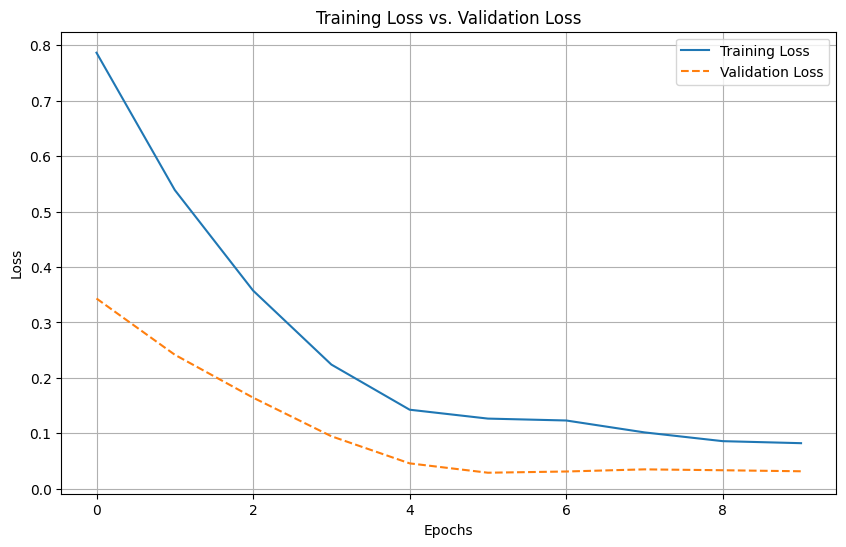

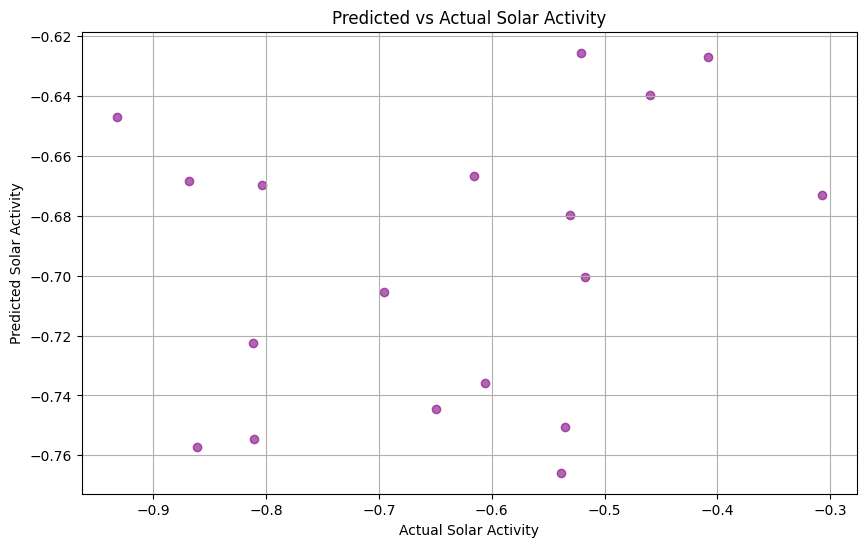

In [12]:
# Main flow
def main():
    # Fetch real-time data
    data = fetch_data()
    
    # Preprocess data
    df, scaled_data = preprocess_data(data)
    
    # Create sequences for LSTM model
    seq_length = 10  # Using past 10 time steps
    X, y = create_sequences(scaled_data, seq_length)
    
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Train the model
    model, history = train_model(X_train, y_train, X_test, y_test)
    
    # Make predictions
    predictions = model.predict(X_test)
    
    # Visualize and save the results
    visualize_and_save(history, y_test, predictions)

if __name__ == "__main__":
    main()

In [6]:
import json

# Calculate prediction errors (residuals)
errors = y_test - predictions.flatten()  # Calculate the residuals

# Prepare the data
data_dict = {
    'y_test': y_test.tolist(),          # Actual flux values
    'predictions': predictions.flatten().tolist(),  # Predicted flux values
    'errors': errors.tolist()           # Prediction errors (residuals)
}

# Save the dictionary as a JSON file
with open('model_output.json', 'w') as json_file:
    json.dump(data_dict, json_file)

# Alternatively, save the data as CSV
import pandas as pd

output_df = pd.DataFrame({
    'actual_values': y_test,
    'predicted_values': predictions.flatten(),
    'errors': errors  # Residuals
})

# Save DataFrame as CSV
output_df.to_csv('model_output.csv', index=False)
